<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/video_notebooks/04_transfer_learning_in_tensorflow_part_1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

See full course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

In [11]:
# Are we using a GPU?
# !nvidia-smi

## Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101 
import urllib.request
from io import BytesIO
import zipfile

# Download the data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
# zip_ref.extractall()
# zip_ref.close()


# Download zipfile
resp = urllib.request.urlopen("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip")
file = BytesIO(resp.read())

# Unzip our data
zip_ref = zipfile.ZipFile(file, "r")
zip_ref.extractall("data")
zip_ref.close()

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("data/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent/test/ramen'.
There are 0 directo

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [5]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "data/10_food_classes_10_percent/train/"
test_dir = "data/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [6]:
# Create TensorBoard callback (functionized beause we need to create a new one for each model)
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

> 🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [9]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies 
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_hub as hub

In [11]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [10]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [12]:
# Create Resnet model 
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

2024-05-28 12:48:56.192045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [14]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240528-124936
Epoch 1/5
24/24 [==============================] - 172s 7s/step - loss: 1.8405 - accuracy: 0.3947 - val_loss: 1.1096 - val_accuracy: 0.6512
Epoch 2/5
24/24 [==============================] - 158s 7s/step - loss: 0.8737 - accuracy: 0.7373 - val_loss: 0.7997 - val_accuracy: 0.7480
Epoch 3/5
24/24 [==============================] - 152s 7s/step - loss: 0.5968 - accuracy: 0.8200 - val_loss: 0.7045 - val_accuracy: 0.7748
Epoch 4/5
24/24 [==============================] - 174s 7s/step - loss: 0.4591 - accuracy: 0.8773 - val_loss: 0.6779 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 175s 8s/step - loss: 0.3622 - accuracy: 0.9227 - val_loss: 0.6517 - val_accuracy: 0.7924


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [16]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


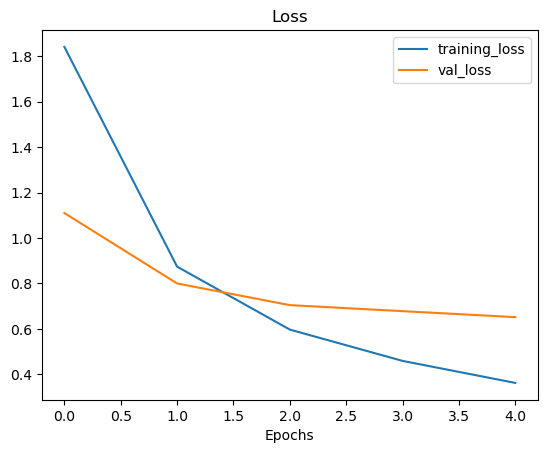

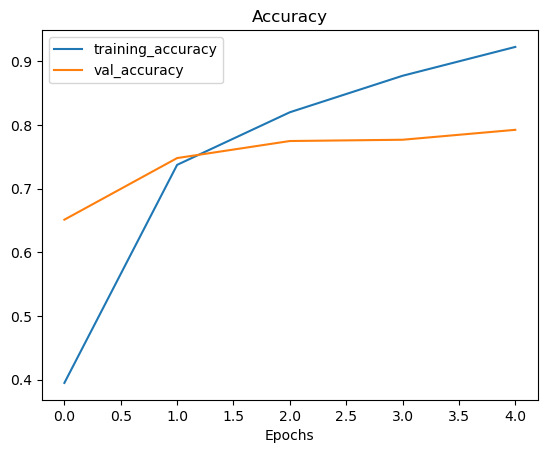

In [17]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [18]:
# Create EfficinetNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%2DB0%20is%20the%20baseline,than%20the%20best%20existing%20CNN.
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240528-132759
Epoch 1/5
24/24 [==============================] - 107s 4s/step - loss: 1.8372 - accuracy: 0.4320 - val_loss: 1.2937 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 90s 4s/step - loss: 1.0521 - accuracy: 0.7867 - val_loss: 0.8592 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 110s 5s/step - loss: 0.7484 - accuracy: 0.8320 - val_loss: 0.6903 - val_accuracy: 0.8472
Epoch 4/5
24/24 [==============================] - 109s 5s/step - loss: 0.6015 - accuracy: 0.8667 - val_loss: 0.6028 - val_accuracy: 0.8624
Epoch 5/5
24/24 [==============================] - 108s 5s/step - loss: 0.5109 - accuracy: 0.8893 - val_loss: 0.5492 - val_accuracy: 0.8656


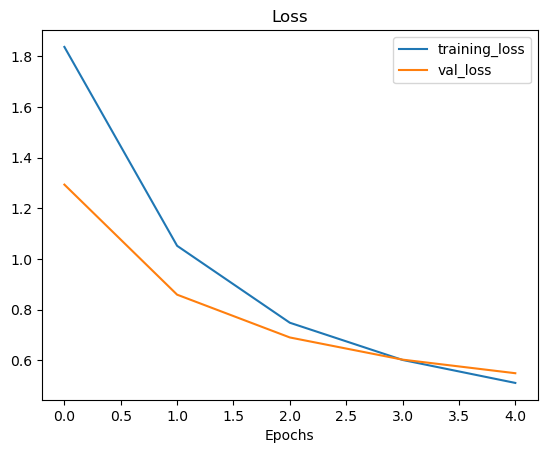

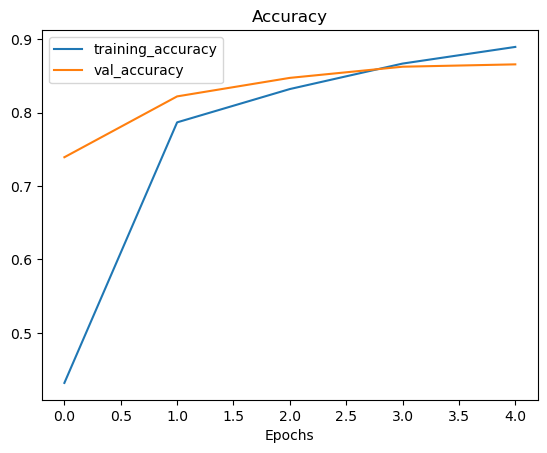

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [26]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/dQBrpdwIRgS2qI0Andv8Yg/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-02-15 02:17:31.857592: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
https://tensorboard.dev/experiment/dQBrpdwIRgS2qI0Andv8Yg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   dQBrpdwIRgS2qI0Andv8Yg
	Created              2021-02-15 02:13:39 (3 minutes ago)
	Updated              2021-02-15 02:13:41 (3 minutes ago)
	Runs                 4
	Tags                 3
	Scalars              40
	Tensor bytes         0
	Binary object bytes  6020432
https://tensorboard.dev/experiment/OAE6KXizQZKQxDiqI3cnUQ/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   OAE6KXizQZKQxDiqI3cnUQ
	Created              2020-09-28 05:46:53
	Upda

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id dQBrpdwIRgS2qI0Andv8Yg

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

2021-02-15 02:19:14.889146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
https://tensorboard.dev/experiment/dQBrpdwIRgS2qI0Andv8Yg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   dQBrpdwIRgS2qI0Andv8Yg
	Created              2021-02-15 02:13:39 (5 minutes ago)
	Updated              2021-02-15 02:13:41 (5 minutes ago)
	Runs                 4
	Tags                 3
	Scalars              40
	Tensor bytes         0
	Binary object bytes  6020432
https://tensorboard.dev/experiment/OAE6KXizQZKQxDiqI3cnUQ/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   OAE6KXizQZKQxDiqI3cnUQ
	Created              2020-09-28 05:46:53
	Upda